# Location-Based Consumer Preference Inference

Notebook used for inspection of the GeoLife dataset, retrieved from  
https://www.microsoft.com/en-us/research/project/geolife-building-social-networks-using-human-location-history/#!downloads  
  
The description of the data can be found in the path `<PATH TO GeoLife>`/Geolife Trajectories 1.3/User Guide-1.3.pdf  

In [2]:
from math import sqrt, cos, sin, pi

import os.path

import sqlite3

from datetime import *
import datetime as dt

from geopy.distance import lonlat, distance, vincenty, geodesic

import pandas as pd

import folium
from folium import plugins
#from sklearn.cluster import OPTICS # not officially included at this stage
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import numpy as np

import random;

#from sklearn.cluster import 

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.utils import read_sample, timedcall
from pyclustering.samples.definitions import SIMPLE_SAMPLES, FCPS_SAMPLES

In [110]:
def template_clustering(sample, eps, minpts, amount_clusters = None, visualize = True, ccore = False):
    #sample = read_sample(path_sample);
    optics_instance = optics(sample, eps, minpts, amount_clusters, ccore);
    (ticks, _) = timedcall(optics_instance.process);
    
    #print("Sample: ", sample, "\t\tExecution time: ", ticks, "\n");
    
    if (visualize is True):
        clusters = optics_instance.get_clusters();
        noise = optics_instance.get_noise();
    
        visualizer = cluster_visualizer();
        visualizer.append_clusters(clusters, sample);
        visualizer.append_cluster(noise, sample, marker = 'x');
        visualizer.show();
    
        ordering = optics_instance.get_ordering();
        analyser = ordering_analyser(ordering);
        
        ordering_visualizer.show_ordering_diagram(analyser, amount_clusters);    
        clust = [item for sublist in clusters for item in sublist]
        encoding = optics_instance.get_cluster_encoding()
        #print("clusters = ", clust, " || # idx = ", len(clust))
        #print("ordering = ", ordering)
    return clusters, clust, ordering, encoding

In [4]:
#### Retrieve data, based on SELECTION from (SQLite) DB stored in DBFILE, located in PATH
def sqlite_2_pd_df(selection, path, dbfile, db):    
    os.chdir(path)
    con=sqlite3.connect(dbfile)
    con.text_factory = sqlite3.OptimizedUnicode
    query = con.execute("SELECT " + selection + " From " + db)
    cols = [column[0] for column in query.description]
    df= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return df.sort_values(['usrID', 'trkID', 'time str'], ascending=[True, True, True])

In [5]:
#### Test example
#### The file GeoLifeDBMINI.db holds a SQLite DB with the 
workdir = '/home/patrickm/projects/GeoLife/'
DBfile  = 'GeoLifeDBMINI.db'

#### Function calculating length of a trajectory
def time_list(time):
    ln = len(time)
    time.sort()
    return (dt.datetime.strptime( time[len(time)-1], '%H:%M:%S') - dt.datetime.strptime(time[0], '%H:%M:%S')).total_seconds()

def tracklengthGEO(lat, long, alt):
    ln = len(lat)
    trkseg = [ geodesic((lat[i+1], long[i+1], alt[i+1]), (lat[i], long[i], alt[i] )).miles for i in range(ln-1) ]
    return sum(trkseg)

def DistSeries(lat, long):
    ln = len(lat)
    d_i = [ (i, geodesic((lat[i+1], long[i+1], alt[i+1]), (lat[i], long[i], alt[i] )).m) for i in range(ln-1) ]
    d_i = d_i + [None]
    return d_i
    
#lat = [1., 1., 1.3, 1.4, 1.6, 1.6, 1.6, 1.7, 1.8, 1.8, 1.8, 1.9]
#lng = [2., 2., 2.3, 2.4, 1.6, 1.6, 1.6, 1.7, 2.8, 2.8, 2.8, 2.9]

#DS = DistSeries(lat, lng)

#print("lat[-1] = ", lat[-1])
#print("Dist list : ", DS, " len(Dist list) = ", len(DS), " || len(lat,lng) = ", len(lat))

## test
time1 = '22:29:01'
time2 = '23:30:02'
time = [time1, time2]
print (time_list(time))

3661.0


In [6]:
#### Create dataframe from SQLite DB
df = sqlite_2_pd_df("*", workdir, DBfile, "GeoLifeDBMINI")
#df.sort_values(['usrID', 'trkID', 'time str'], ascending=[True, True, True])

In [7]:
# Pandas gymnastics

tmp = df.copy(deep=True)
tmp.reset_index()
tmp.set_index(['usrID','trkID'], inplace = True)
tmp = tmp.groupby(['usrID', 'trkID']).size().to_frame('no of markers')
print(tmp.head(100))
print(tmp.reset_index())


tmp2 = df.copy(deep=True)
tmp2.reset_index()
#print (tmp2.loc[tmp2['usrID']==2].head())

                      no of markers
usrID trkID                        
0     20081023025304            908
      20081024020959            244
      20081026134407            745
      20081027115449             50
      20081028003826           1477
      20081029092138             21
      20081029093038            182
      20081103101336              7
      20081103232153           2231
      20081110013637            272
      20081111001704           1477
      20081112023003            681
      20081112091400             27
      20081113034608            494
      20081114015255            337
      20081114101436            305
      20081115010133            281
      20081116085532             12
      20081117051133             81
      20081117155223            314
      20081118095005             32
      20081118095400            254
      20081118162008              7
      20081119012806             81
      20081119112035            419
      20081120035736        

,index,Lat,Long,Alt,no days,date str,time str,usrID,trkID
0,67366,39.984702,116.318417,492,39744.120185,2008-10-23,02:53:04,0,20081023025304
1,67367,39.984683,116.318450,492,39744.120255,2008-10-23,02:53:10,0,20081023025304
2,67368,39.984686,116.318417,492,39744.120313,2008-10-23,02:53:15,0,20081023025304
3,67369,39.984688,116.318385,492,39744.120370,2008-10-23,02:53:20,0,20081023025304
4,67370,39.984655,116.318263,492,39744.120428,2008-10-23,02:53:25,0,20081023025304
5,67371,39.984611,116.318026,493,39744.120486,2008-10-23,02:53:30,0,20081023025304
6,67372,39.984608,116.317761,493,39744.120544,2008-10-23,02:53:35,0,20081023025304
7,67373,39.984563,116.317517,496,39744.120602,2008-10-23,02:53:40,0,20081023025304
8,67374,39.984539,116.317294,500,39744.120660,2008-10-23,02:53:45,0,20081023025304
9,67375,39.984606,116.317065,505,39744.120718,2008-10-23,02:53:50,0,20081023025304


In [8]:
usr = 0

# tracks
mrks = df.loc[df['usrID'] == usr].sort_values(by=['trkID', 'time str'], ascending=True)
print(mrks)

count = 0
for i in mrks['trkID'].unique():
    lat = []
    long= []
    alt = []
    time= []
    count += 1
    
    lat = [lt for lt in mrks.loc[mrks['trkID']==str(i)]['Lat'] ]
    long = [lng for lng in mrks.loc[mrks['trkID']==str(i)]['Long'] ]
    alt = [al for al in mrks.loc[mrks['trkID']==str(i)]['Alt'] ]
    time = [tm for tm in mrks.loc[mrks['trkID']==str(i)]['time str'] ]#.apply(lambda x: dt.strptime(x , '%H:%M:%S').dt.total_seconds() ) ] 
    #print(lat)
    if count%20 == 0: print ("Trajectory ", i, " is ", tracklengthGEO(lat,long,alt), " miles long,  time spent :", time_list(time), " sec,   crude avg. speed : ", tracklengthGEO(lat,long,alt)/time_list(time)*3600., " mph")


#print (mrks.loc[mrks['time str'] == '02:53:10'].head(20))

             Lat        Long  Alt       no days    date str  time str  usrID  \
67366  39.984702  116.318417  492  39744.120185  2008-10-23  02:53:04      0   
67367  39.984683  116.318450  492  39744.120255  2008-10-23  02:53:10      0   
67368  39.984686  116.318417  492  39744.120313  2008-10-23  02:53:15      0   
67369  39.984688  116.318385  492  39744.120370  2008-10-23  02:53:20      0   
67370  39.984655  116.318263  492  39744.120428  2008-10-23  02:53:25      0   
67371  39.984611  116.318026  493  39744.120486  2008-10-23  02:53:30      0   
67372  39.984608  116.317761  493  39744.120544  2008-10-23  02:53:35      0   
67373  39.984563  116.317517  496  39744.120602  2008-10-23  02:53:40      0   
67374  39.984539  116.317294  500  39744.120660  2008-10-23  02:53:45      0   
67375  39.984606  116.317065  505  39744.120718  2008-10-23  02:53:50      0   
67376  39.984568  116.316911  510  39744.120775  2008-10-23  02:53:55      0   
67377  39.984586  116.316716  515  39744

## Stay Points location
  
  In the following we try out an algorithm used to find so-called *stay points*. Currently it appears ugly, and I am hoping that a more elegant and efficient algorithm will be found.  
  The algorithm works as follows:
  * For each user $u_i$, for each trajectory $traj_{u_i, j}$: run a clustering algorithm (SPcandidates) among the time stamps pertaining to each set of coordinates. This creates a list of time stamps $\{ t_m, \ldots, t_n \}$ where $| t_i - t_j | \geq T_{\mathrm{threshold}}$  (20min in this particular case), for $t_i, t_j \in \{ t_m, \ldots, t_n \}$.
  * Use the same type of clustering algorithm (clust) to see if the coordinates corresponding to the aforementioned timestamps fulfill the criteria $\mathrm{dist}\left ( (\mathrm{lat}_i, \mathrm{long}_i), (\mathrm{lat}_j, \mathrm{long}_j) \right) \leq D_{\mathrm{threshold}}$ (200m in this particular case)
  * If the time stamp and corresponding coordinates fulfull the abovemenentioned criteria then a *stay point* is calculated

In [86]:
def TimeClust(timelst):
    prev = None
    group = []
    Tth = 20.*60.
### Step one: cluster wrt. time
#    print ("time prev : ", timelst)
    for tm in timelst:
        if not prev or (abs(time_list([tm, prev])) >= Tth):
            group.append(tm)
        else:
            yield group
            group = [tm]
        prev = tm
    if group:
        yield group

tmpdct = dict(enumerate(TimeClust(time), 1)) # dictionary of time stamps more than 20 min apart
times = tmpdct.values()

def DistClust(lat, long):
    coords = list(zip(lat,long))
    #coords = map(lambda x,y : (x,y),lat,long)
    #print("DO IT NOW!!! ", coords)
    prev = (None, None)
    group = []
    Dth = 200.
    #test = (geodesic(coords, prev).m)
    for coord in coords:
        if not prev or ((geodesic(coord, prev).m) <= Dth):
            group.append(coord)
        else:
            yield group
            group = [coord]
        prev = coord
    if group:
        yield group
        
#dict(enumerate(TimeClust(time), 1))

Tt = 20 * 60. # threshold in seconds
Dt = 200. # Distance threshold in meters

SPs = []
SP  = []
LocHistTmp = {}
LocHist = {}
#for usr in df['usrID'].unique():
for usr in [0,1,2,3]:
    SPcoords = []  # Stay point coordinates for a given user
    SPtimes  = []  # Corresponding  arrival and leaving times of a stay point
    mrks = df.loc[df['usrID'] == usr]#.sort_values(by=['trkID', 'time str'], ascending=True)    
    #print(mrks.head(50))
    for i in mrks['trkID'].unique():
        count += 1
        time = [tm for tm in mrks.loc[mrks['trkID']==str(i)]['time str'] ] # Distinct time stamps for the trajectory in question
        tmarrs = [time for time in dict(enumerate(TimeClust(time), 1)).values() if len(time)>1] # Create clusters of successive time stamps with T2-T1>20min
        for tmarr in tmarrs:
            # for each time cluster find the coordinates that fulfill D(coord1, coord2) < 200 m
            latdict  = {lt: tim for tim in tmarr for lt in mrks.loc[(mrks['trkID']==str(i) )& (mrks['time str'] == str(tim)) ]['Lat'] }
            longdict = {lng: tim for tim in tmarr for lng in mrks.loc[(mrks['trkID']==str(i) )& (mrks['time str'] == str(tim)) ]['Long'] }
            coorddict = dict(enumerate(DistClust(latdict.keys(),longdict.keys()), 0))
            for idx, coords in coorddict.items():
                if len(coords) > 1:
                    LocHistTmp.update( { usr:[coords, latdict[coords[0][0]], latdict[coords[len(coords)-1][0] ] ] } )
                    sumlat = 0.
                    sumlong= 0.
                    for coord in coords:
                        sumlat += coord[0]
                        sumlong+= coord[1]
                    sp = (sumlat/len(coords), sumlong/len(coords))
                    SPcoords.append(sp)
                    SPtimes.append((latdict[coords[0][0]], latdict[coords[len(coords)-1][0] ]))
                    LocHist.update( { usr:(SPcoords, SPtimes) } )
        
StayPoints = dict(enumerate(SPs, 0))
print("~~~ FINAL ~~~")
print("Stay Points : ", LocHist)

~~~ FINAL ~~~
Stay Points :  {0: ([(40.008898, 116.321518), (40.011466999999996, 116.2967925), (39.974488, 116.332133), (40.009226, 116.32045450000001), (40.0007515, 116.324095), (39.9999165, 116.32486), (40.0100695, 116.322222), (40.007423, 116.319784), (40.0089225, 116.320954), (39.999978, 116.3244375), (39.9934085, 116.3275835), (39.999883999999994, 116.3232145), (40.0075245, 116.32043200000001), (40.0000615, 116.326813), (39.9999845, 116.327422), (39.9999065, 116.32746700000001), (40.0109555, 116.323478), (39.990714499999996, 116.31729849999999), (39.9906615, 116.31727649999999), (40.000081, 116.327069), (40.006631, 116.3170095), (40.007127, 116.32068050000001), (39.9999885, 116.32737700000001), (40.007928, 116.31948750000001), (40.006229000000005, 116.325703), (40.009761, 116.3151755), (40.0096785, 116.3151215), (40.0097275, 116.3151035), (40.0095835, 116.315026), (40.00986, 116.3149655), (39.937388, 116.3899135), (39.9444895, 116.375504), (40.0793095, 116.5874665), (40.0070280000

In [103]:
#print(LocHist[0][0][0])
SPall = []
for usr in [0,1,2,3]:
    for coordlist in LocHist[usr][0]:
        #print ("coordlist = ", coordlist)
        #for coord in coordlist:
        #    print("coord = ", coord)
        SPall.append(coordlist )
#SPall = [ sp for coordlst in LocHist[usr][0] for usr in [0,1,2,3]]
SPalldict = {i:SPall[i] for i in range(len(SPall))}
print(list(SPalldict.values()))

[(40.008898, 116.321518), (40.011466999999996, 116.2967925), (39.974488, 116.332133), (40.009226, 116.32045450000001), (40.0007515, 116.324095), (39.9999165, 116.32486), (40.0100695, 116.322222), (40.007423, 116.319784), (40.0089225, 116.320954), (39.999978, 116.3244375), (39.9934085, 116.3275835), (39.999883999999994, 116.3232145), (40.0075245, 116.32043200000001), (40.0000615, 116.326813), (39.9999845, 116.327422), (39.9999065, 116.32746700000001), (40.0109555, 116.323478), (39.990714499999996, 116.31729849999999), (39.9906615, 116.31727649999999), (40.000081, 116.327069), (40.006631, 116.3170095), (40.007127, 116.32068050000001), (39.9999885, 116.32737700000001), (40.007928, 116.31948750000001), (40.006229000000005, 116.325703), (40.009761, 116.3151755), (40.0096785, 116.3151215), (40.0097275, 116.3151035), (40.0095835, 116.315026), (40.00986, 116.3149655), (39.937388, 116.3899135), (39.9444895, 116.375504), (40.0793095, 116.5874665), (40.007028000000005, 116.32016949999999), (39.99

## Experimenting with the OPTICS clustering algorithm

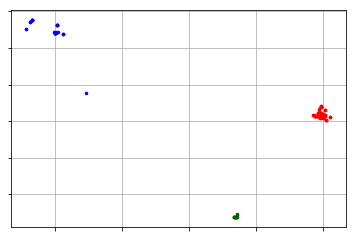

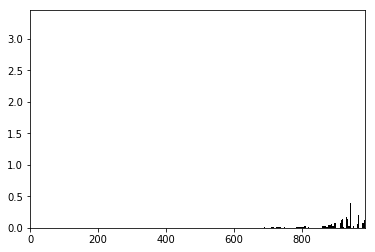

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

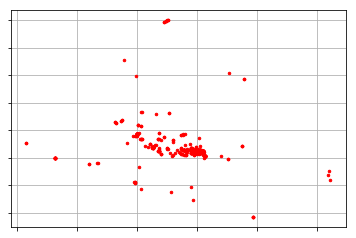

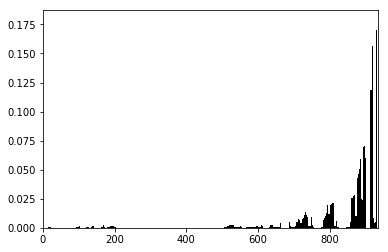

[[0, 1, 2, 4, 3, 5, 6, 7, 8, 10, 9, 11, 12, 14, 13, 15, 17, 16, 19, 18, 21, 20, 22, 24, 23, 26, 25, 27, 29, 28, 30, 32, 31, 33, 34, 36, 35, 37, 38, 39, 41, 40, 43, 42, 45, 44, 47, 46, 49, 48, 51, 50, 52, 54, 53, 55, 56, 57, 59, 58, 60, 62, 61, 63, 65, 64, 66, 67, 69, 68, 70, 71, 73, 72, 74, 75, 77, 76, 79, 78, 81, 80, 83, 82, 85, 84, 87, 86, 89, 88, 91, 90, 93, 92, 95, 94, 97, 96, 98, 100, 99, 101, 102, 103, 104, 105, 107, 106, 109, 108, 110, 112, 111, 113, 114, 116, 115, 117, 118, 119, 121, 120, 122, 123, 125, 124, 126, 127, 129, 128, 131, 130, 133, 132, 134, 136, 135, 137, 139, 138, 140, 142, 141, 143, 145, 144, 147, 146, 148, 149, 150, 152, 151, 154, 153, 156, 155, 157, 158, 159, 160, 162, 161, 163, 165, 164, 167, 166, 169, 168, 171, 170, 173, 172, 175, 174, 177, 176, 178, 180, 179, 182, 181, 184, 183, 186, 185, 188, 187, 190, 189, 192, 191, 193, 194, 195, 196, 197, 198, 199, 201, 200, 203, 202, 204, 205, 206, 207, 209, 208, 210, 211, 213, 212, 215, 214, 217, 216, 218, 219, 221, 220

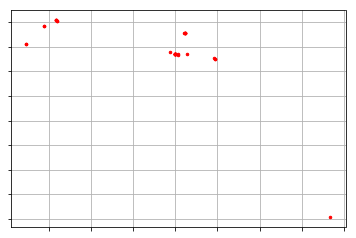

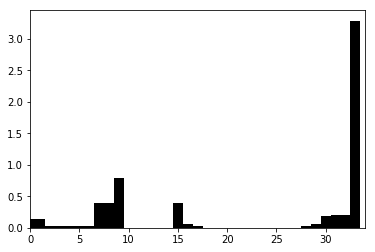

[[0, 1, 3, 2, 5, 4, 7, 6, 9, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]]


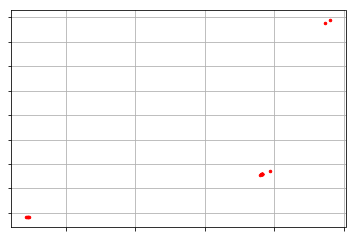

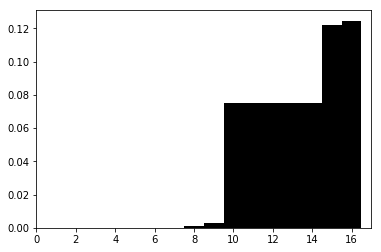

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]


In [112]:
eps = 5.2
minpts = 5
clusters, clust, order, encoding = template_clustering(list(SPalldict.values()), eps, minpts)
clust.sort()
#print(clust, len(clust), dict(enumerate(clust,0)))
print(dict(enumerate(clust,0)))
print(clusters)
print("enc : ", encoding)
#for minpts in [3,5,7,9,11,15,20]:
#    for eps in [0.05, 0.1, 0.15, 0.20, 0.25]:
#        template_clustering(SPs, eps, minpts)
for cluster in clusters:
    SPtmp = [SPalldict[idx] for idx in cluster]
    clusters_tmp, clust_tmp, order_tmp, encoding_tmp = template_clustering(SPtmp, eps, minpts)
    print(clusters_tmp)

## Playing with Folium
  
  Here we play with the folium package for python and plot markers corresponding to trajectory files.

In [ ]:
BEIJING_COORDINATES = ( 39.9062170, 116.3912757 )
# for speed purposes
MAX_RECORDS = 1000
  
# create empty map zoomed in on Beijing
map_beijing = folium.Map(location=BEIJING_COORDINATES, zoom_start=12)
map_beijing.position
# add a marker for every record in the filtered data, use a clustered view

usr = 0

tmp  = df.copy(deep=True)
main = tmp[tmp['trkID'] == str(20090415074008)]
lat  = main['Lat'].tolist()
long = main['Long'].tolist()

coord = []

for lt in lat:
    coord.append( (lt, long[ lat.index(lt) ] ) ) 
    print("coord = ", lt, long[ lat.index(lt) ])
    folium.Marker(location = (lt, long[ lat.index(lt) ] ) ).add_to(map_beijing)
    
#for each in crimedata[0:MAX_RECORDS].iterrows():
#    folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']]).add_to(mapsf)
#map.save(outfile = "test.html")
map_beijing
